# Phase contrast SXCT scan of Egyptian blue specimen - pore size analysis

- By Abdellatif Saadaldin, [Gianluca Iori](https://github.com/gianthk), 2024
- Code licence: MIT
- Narrative licence: CC-BY 
- Created on:  18.05.2024
- Last update: 22.07.2024

| Sample   | Egyptian blue                            |
|:-----------------------|:-------------------------------|
| Scan name              | egyptian_blue-20240229T135258   |
| Energy                 | 45 keV                         |
| Detector               | Det 2 (Hasselblad system)      |
| Camera                 | PCO.edge 5.5          |
| Voxel size             | 3.1 um                         |
| SDD                    | 300 mm                         |

---
## Pre processing

Binary masks and the local thickness map used for this notebook were generated in ORS Dragonfly (Comet Technologies Canada Inc., Montreal, Canada) as follows:

### 1. Median filtering
The first step in our data processing workflow is applying  a 3D median filter. This filter helps in reducing noise from the data, making processing  more effective.

### 2. K-means segmentation
We utilized K-means segmentation to identify and segment the pores within the 3D volume data. K-means is a clustering algorithm that partitions data into K distinct clusters based on feature similarity. It aims to minimize the variance within each cluster, effectively grouping similar data points together. We used the algorithm implemented in ORS Dragonfly. After testing, using 2 clusters was not efficient for segmenting the pores. So we used 3 clusters and 4 Iterations. This segmentation effectively distinguished between different pore structures in our data.

### 3. Binary mask refinement
After segmentation, we extracted the pore cluster applying morphological operations aimed at refining the segmentation. In particular, we applied a 3D image opening operation (one step of 3D erosion followed by one 3D dilation; kernel size: 3 voxels). This operation is designed to eliminate very small pores that may be considered noise or artifacts. 

### 4. Segmentation of large pores and thin void network
We applied a second 3D image opening step with a larger kernel (size: 10 voxels, corresponding to 28 micrometer). This step is designed to remove thin porosities and isolate in this way only large pores with a regular-shape. Following this step, a second mask of the thin, remaining voids was generated subtracting the large pores mask from the pores cluster obtained in step 3.

### 5. multi-ROI segmentation
From the mask of large size pores we generated a multi-Region-Of-Interest (ROI) of all large pores. 

### 6. Porosity calculation
The porosity of Egyptian blue and the relative contribution of large pores and thin void network are calculated taking ratios of the respective binary mask volumes to te volume of the analyzed sample portion.

### 7. Large pore statistics
The following metrics are computed from the large pores multi-ROI: pore volume, sphericity, aspect ratio, max. Feret diameter.

### 8. Thin void network thickness
A local thickness image is computed from the mask of thin voids obtained at point 4 above.

---
# Aims
1. Read `.CSV` file of Max. Feret diameter of large spheric particles 
2. Load volume thickness map of small size pore network
3. Plot distribution of large pores diameter
4. Plot histogram of thin pore thickness

---
# Computational workflow

## Configuration and import of Python modules
- Local paths to data and work folder location should be updated
- Download `recon_utils` [here](https://github.com/gianthk/recon_utils) and change the cell below accordingly

In [3]:
import os
import sys
sys.path.append('./../../recon_utils')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage, stats # , misc
from recon_utils import read_tiff_stack, plot_midplanes

Configure working folder (change this to your local path)

In [4]:
# beatsbs@BL-BEATS-WS01
work_folder = "/PETRA/SED/BEATS/IH/2024_recon/Publications/CH_2024/egyptian_blue"

In [5]:
res_folder = os.path.join(work_folder, "results")

Matplotlib plotting configuration

In [54]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

plt.style.use("dark_background")

## Load data
### Load scalar dataset of small pore network volume thickness

In [10]:
input_file = os.path.join(work_folder,'small_voids_volume_thickness/slice_001.tif')

In [11]:
data_3D = read_tiff_stack(input_file)

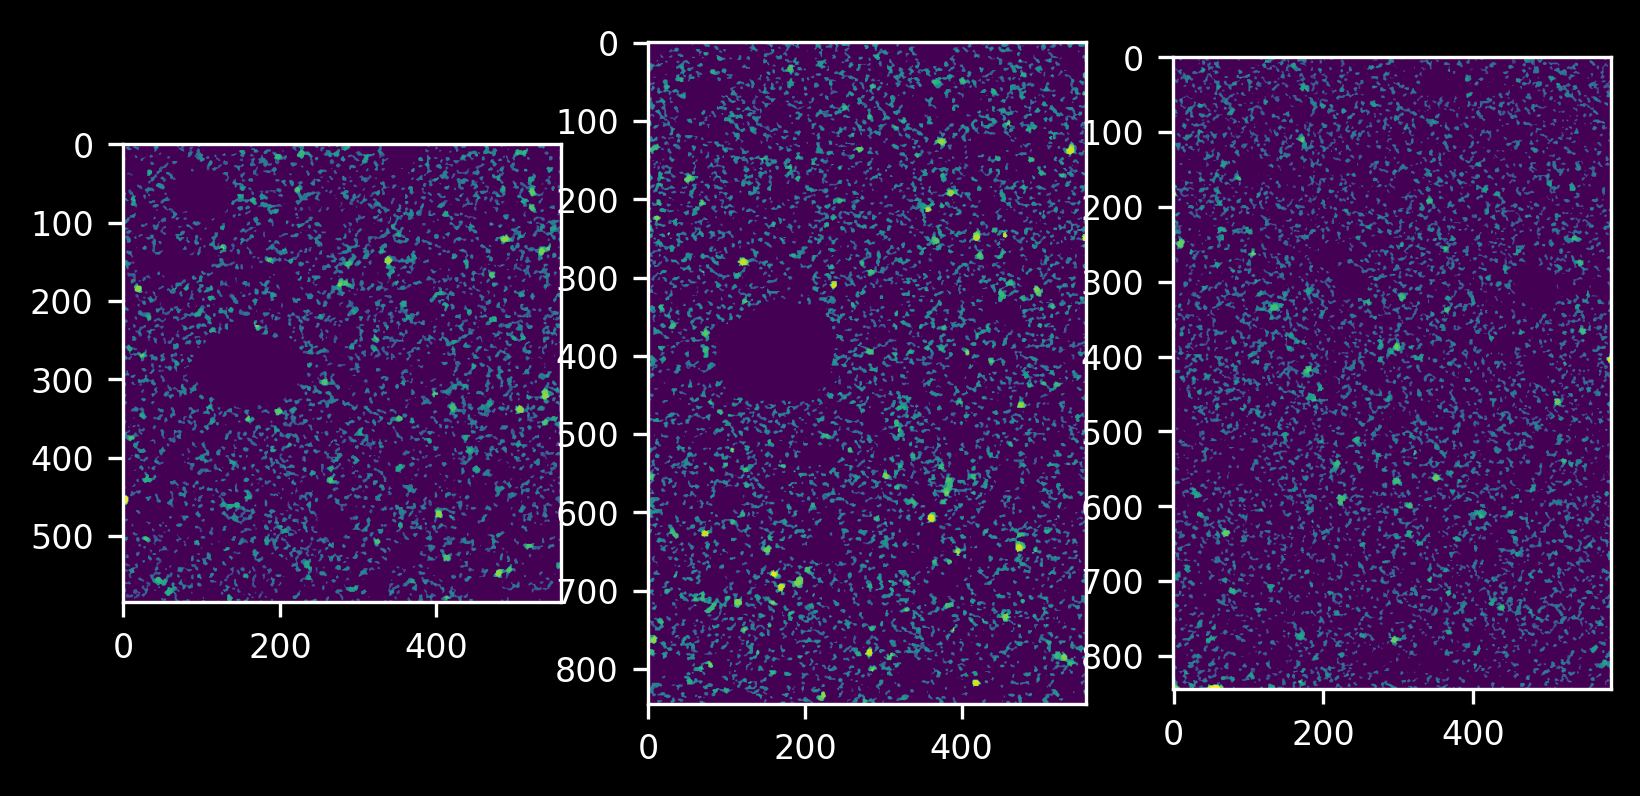

In [12]:
plot_midplanes(data_3D)

### Load pore measurements
- Pore measurements were performed in ORS Dragonfly
- The measurement was applied only to large pores, which are excluded from the thickness map above

In [13]:
results_file = os.path.join(work_folder, 'blobs_large_multiROI_measurements.csv')

In [14]:
names = ['Time Step', 'Label Index', 'Name (NA)', 'Voxel count', 'Volume (mm³)', 'Max Feret Diameter (mm)', 'Sphericity']

In [15]:
measurements = pd.read_csv(results_file, sep=';', names=names, skiprows=[0])

In [16]:
measurements.head()

,Time Step,Label Index,Name (NA),Voxel count,Volume (mm³),Max Feret Diameter (mm),Sphericity
0,0,1,NaN,400.0,0.000095,0.069573,0.982406
1,0,2,NaN,400.0,0.000095,0.069589,0.982406
2,0,3,NaN,400.0,0.000095,0.069595,0.979847
3,0,4,NaN,400.0,0.000095,0.069318,0.981521
4,0,5,NaN,400.0,0.000095,0.071472,0.979847


## Plot pores diameter distribution
Only large pores are considered in the previous segmentation steps. The Max. Feret diameter is taken as the pore diameter. 

In [17]:
diameter = measurements['Max Feret Diameter (mm)']

In [19]:
kde = stats.gaussian_kde(diameter)
x = np.linspace(diameter.min(), diameter.max(), 128)
p = kde(x)

In [55]:
matplotlib.rcParams['figure.figsize'] = 6,3

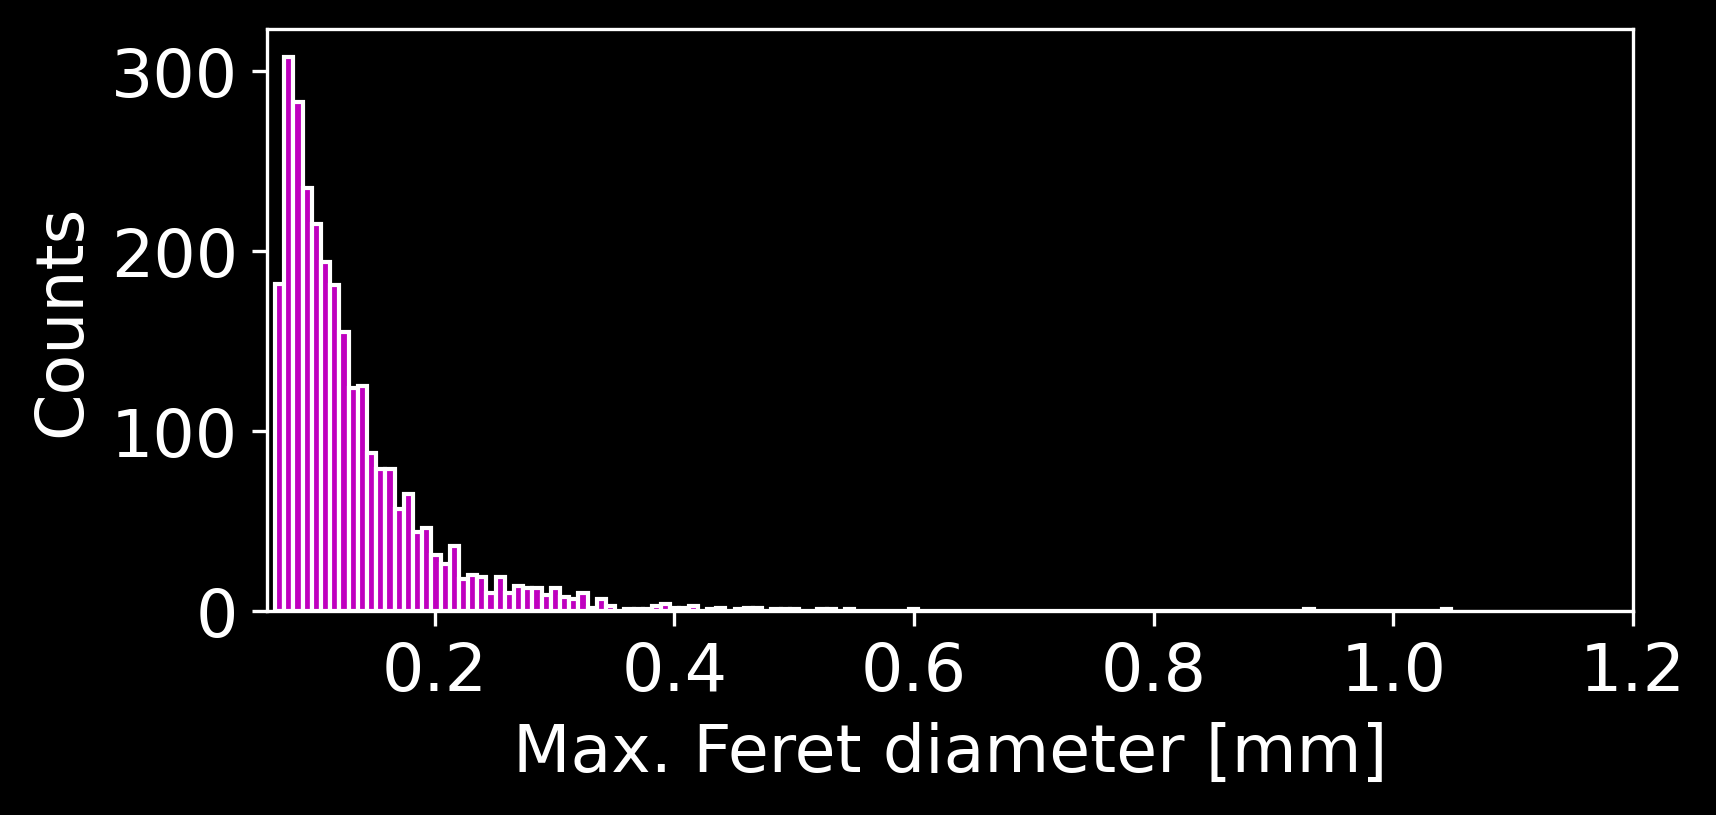

In [60]:
fig, axs = plt.subplots(1)
axs.hist(measurements['Max Feret Diameter (mm)'], bins=128, color='m', edgecolor="w", label='Max. Feret diameter [mm]') # , density=True 
# axs.plot(x, p, 'r', label='ksdensity')
axs.set_xlabel("Max. Feret diameter [mm]")
axs.set_ylabel("Counts")
axs.set_xlim(0.06, 1.2)
fig.tight_layout()
fig.savefig(os.path.join(res_folder, 'hist_large_voids_diameter.png'))

In [63]:
print('Avg.: ', np.mean(measurements['Max Feret Diameter (mm)']), ' [mm]')
print('Std.: ', np.std(measurements['Max Feret Diameter (mm)']), ' [mm]')
print('MIN.: ', np.min(measurements['Max Feret Diameter (mm)']), ' [mm]')
print('MAX.: ', np.max(measurements['Max Feret Diameter (mm)']), ' [mm]')
# print(np.median(data_3D[data_3D>0])*1e3)

Avg.:  0.13111636905082671  [mm]
Std.:  0.06747404582354039  [mm]
MIN.:  0.0667710187908467  [mm]
MAX.:  1.048528314531105  [mm]


## Median filter of volume thickness image

In [52]:
data_3D_filtered = ndimage.median_filter(data_3D.astype('float64'), 3)

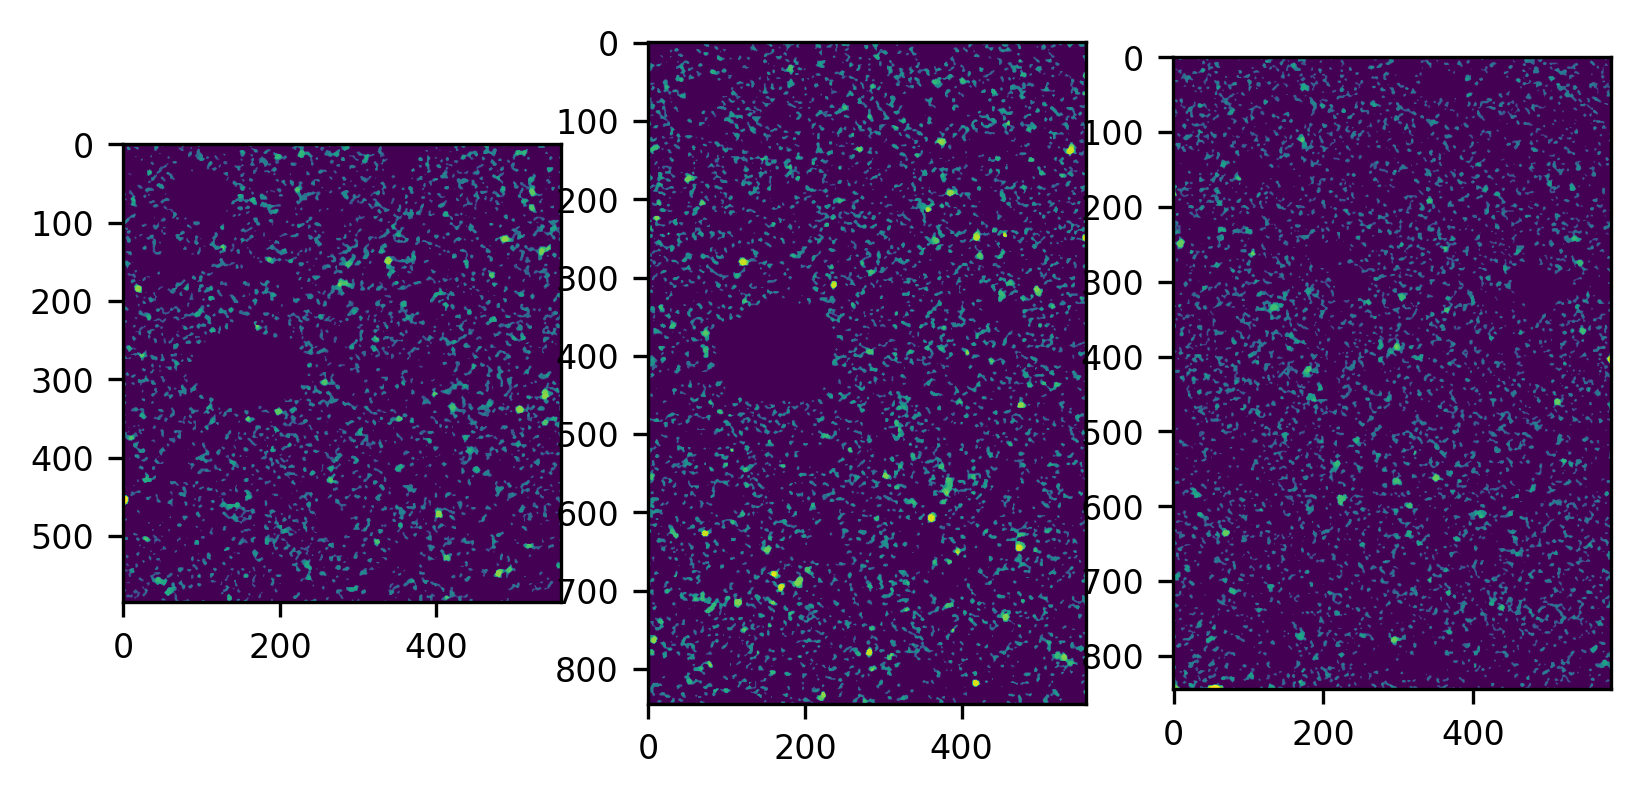

In [53]:
plot_midplanes(data_3D_filtered)

## Plot histogram of the thickness of fine pore network

In [56]:
data_3D_filtered.dtype

dtype('float64')

In [57]:
thickness = 1e3*np.random.choice(data_3D_filtered[data_3D_filtered > 0], 1000000)

In [60]:
kde = stats.gaussian_kde(thickness)
x = np.linspace(thickness.min(), thickness.max(), 128)
p = kde(x)

Text(0, 0.5, 'Counts')

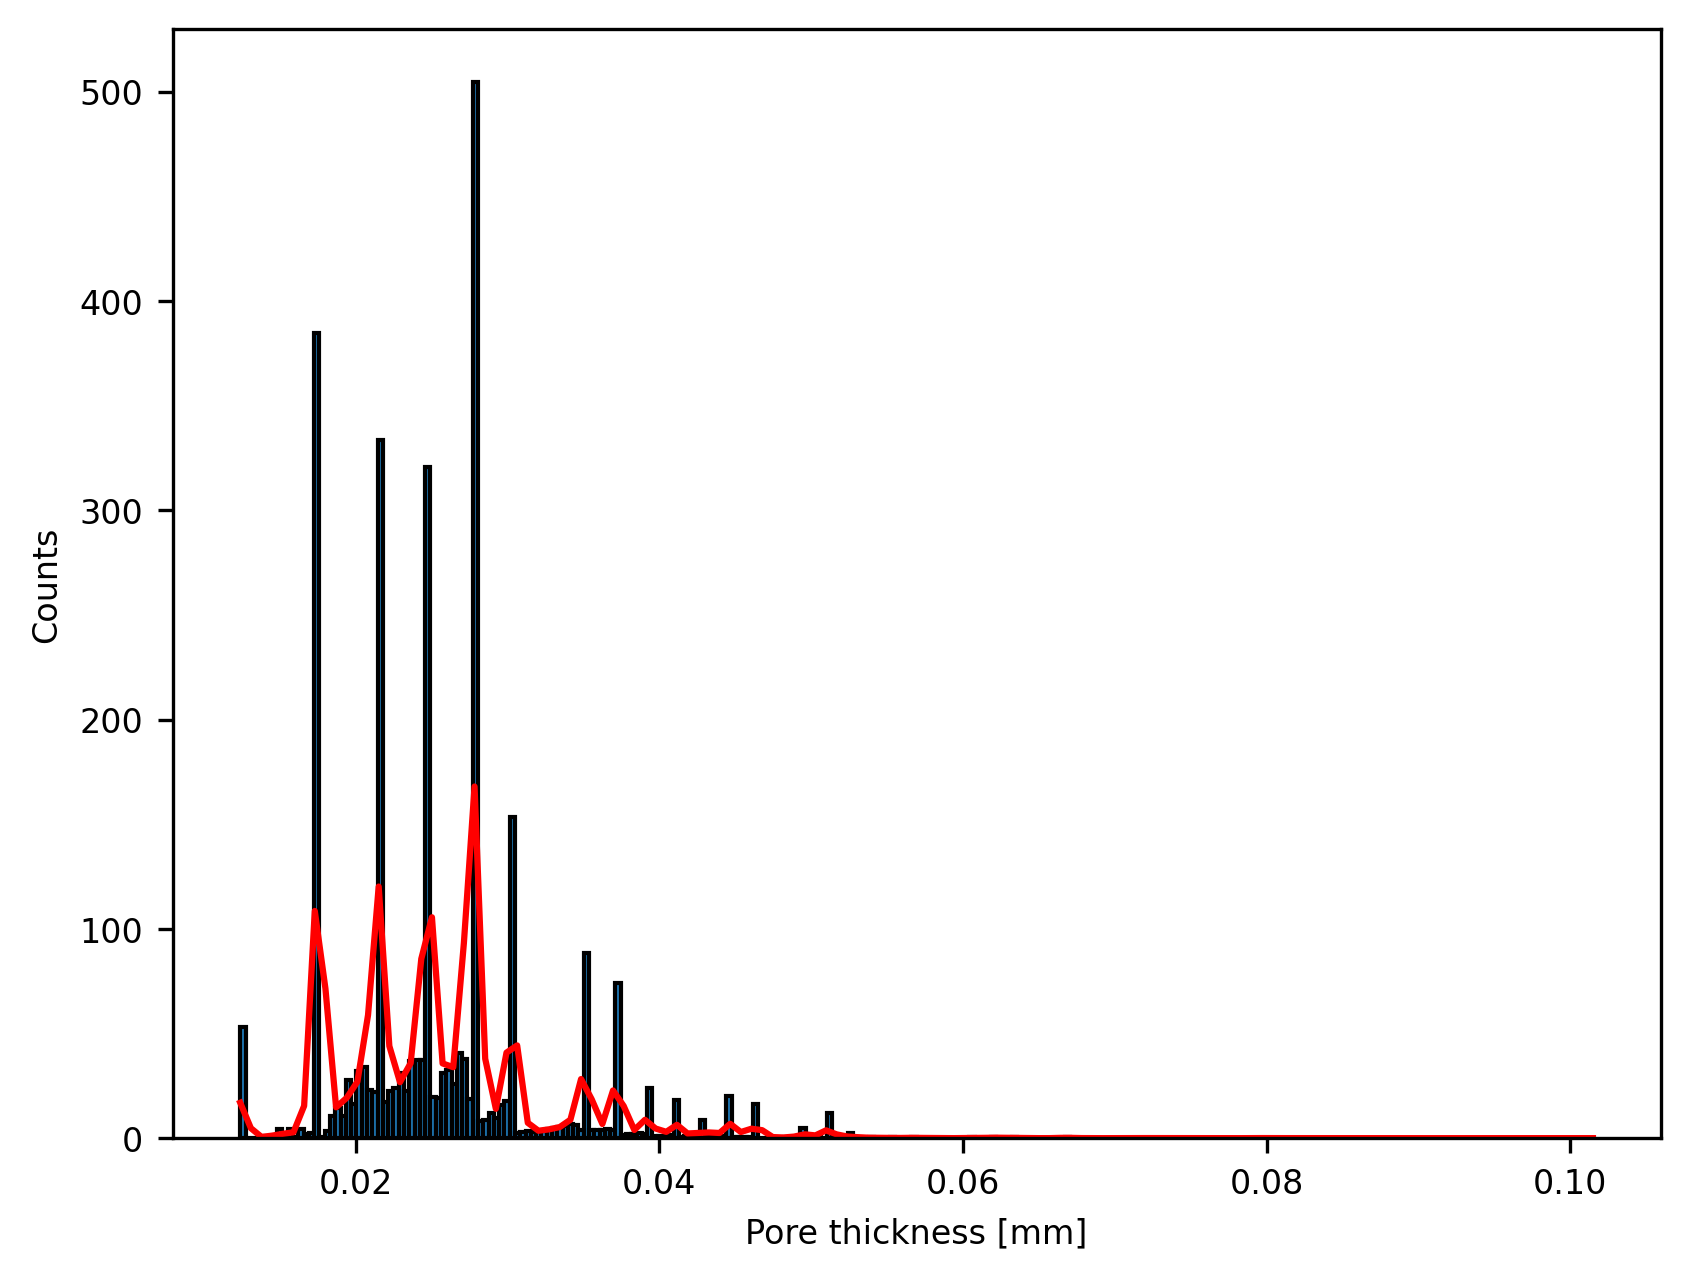

In [70]:
plt.figure()
plt.hist(thickness, bins=256, edgecolor="k", density=True, label='Pore thickness')
plt.plot(x, p, 'r', label='ksdensity')
plt.xlabel("Pore thickness [mm]")
plt.ylabel("Counts")
# plt.legend()

In [64]:
# print(np.median(thickness))
thickness = data_3D[data_3D>0]*1e3

print('Avg.: ', np.mean(thickness), ' [mm]')
print('Std.: ', np.std(thickness), ' [mm]')
print('MIN.: ', np.min(thickness), ' [mm]')
print('MAX.: ', np.max(thickness), ' [mm]')

Avg.:  0.025582757  [mm]
Std.:  0.0068204957  [mm]
MIN.:  0.012399999  [mm]
MAX.:  0.10149837  [mm]
